In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as op
from scipy import stats
import emcee
import corner
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [3]:
def c4(em):
    return np.sqrt(2/(em-1.))*gamma(em/2.)/gamma((em-1.)/2)

In [4]:
df=pd.read_csv("NED26.05.1-D-12.1.0-20160501.csv",skiprows=12)
df=df[np.isnan(df['redshift (z)'])]
df=df[df['D (Mpc)']<500]
df=df[np.isfinite(df.err)]
df=df[df['D (Mpc)']>35]

In [5]:
df.shape

(54398, 15)

In [6]:
df.head()

,Exclusion Code,D,G,Galaxy ID,m-M,err,D (Mpc),Method,REFCODE,SN ID,redshift (z),Hubble const.,Adopted LMC modulus,Date (Yr. - 1980),Notes
4,NaN,3,2,UGC 12889,34.16,0.40,68.0,Tully-Fisher,2007A&A...465...71T,NaN,NaN,NaN,NaN,27,mean
5,NaN,4,2,UGC 12889,34.66,0.45,85.6,Tully-Fisher,2007A&A...465...71T,NaN,NaN,NaN,NaN,27,K
6,NaN,5,2,UGC 12889,34.68,0.47,86.1,Tully-Fisher,2007A&A...465...71T,NaN,NaN,NaN,NaN,27,H
7,NaN,6,2,UGC 12889,34.70,0.46,86.9,Tully-Fisher,2007A&A...465...71T,NaN,NaN,NaN,NaN,27,J
8,NaN,7,3,KUG 2357+228,33.52,0.20,50.6,Tully-Fisher,2013AJ....146...86T,NaN,NaN,74.4,NaN,33,NaN


In [7]:
for i in np.unique(df.Method):
    df1=df[df.Method==i]
    print i,df1.shape

AGN time lag (24, 15)
Black Hole (12, 15)
CMD (3, 15)
Cepheids (4, 15)
D-Sigma (815, 15)
Dwarf Galaxy Diameter (6, 15)
FP (11038, 15)
Faber-Jackson (527, 15)
GCLF (36, 15)
GeV TeV ratio (3, 15)
H I + optical distribution (1, 15)
HII region diameter (1, 15)
IRAS (2089, 15)
Maser (6, 15)
Ring Diameter (71, 15)
SBF (236, 15)
SGRB (5, 15)
SNII optical (319, 15)
SNII radio (6, 15)
SNIa (1988, 15)
SZ effect (5, 15)
Sosies (129, 15)
Tertiary (92, 15)
Tully est (264, 15)
Tully-Fisher (36718, 15)


In [8]:
np.unique(df1.Method)

array(['Tully-Fisher'], dtype=object)

In [9]:
listcut=np.unique(df1['Galaxy ID'])

In [10]:
listcut

array(['2MASX J00024069+0846251', '2MASX J00041398-5113247',
       '2MASX J00062236-5010027', ..., 'WISEP J041245.99+294612.5',
       'WKK 2029', 'ZwCl 1115.2+3013 03'], dtype=object)

In [ ]:
k=0
for i in listcut:
    dfilter=(df1['Galaxy ID']==i)
    if(len(df1[dfilter])>8):
        dummy=df1[dfilter]
        dumerr=disterr[dfilter]
        em=len(dumerr)
        dumw=dumerr/dummy['D (Mpc)']
        dumw=np.sqrt(dumerr)
        wave=(dummy['D (Mpc)']*1/dumw**2).sum()/(1/dumw**2).sum()
        wstd=np.sqrt((((dummy['D (Mpc)']-wave)**2)*1/dumw**2).sum()/((em-1./em)*(1/dumw**2).sum()))
        uwerr=dummy['D (Mpc)'].std()/c4(em)
        uwav=dummy['D (Mpc)'].mean()
        werr=wstd/c4(em)
        errlist[k,0]=wave
        errlist[k,1]=em
        errlist[k,2]=werr
        errlist[k,3]=dumerr.mean()
        errlist[k,4]=uwerr
        errlist[k,5]=uwav
        errlist[k,6]=(dumerr/dummy['D (Mpc)']).mean()
    k+=1
# seria bueno calcular el promedio de dumerr/dummy['D']

In [11]:
disterr=0.461*df1['D (Mpc)']*df1.err

In [13]:
import sklearn.mixture
gmm = sklearn.mixture.GMM()

In [239]:
%%time
errlist=np.zeros((len(listcut),9))
k=0
nbins=1000

for i in listcut:
    dfilter=(df1['Galaxy ID']==i)
    if(len(df1[dfilter])>8):
        data=np.array([])
        dummy=df1[dfilter]
        for i in dummy.D:
            otherfilter=(dummy.D==i)
            AA=10**(np.random.normal(dummy['m-M'][otherfilter],dummy['err'][otherfilter],nbins)/5.+1)
            data=np.hstack((data,AA))            
        dumerr=disterr[dfilter]
        em=len(df1[dfilter])
        r = gmm.fit(data[:, np.newaxis])
        errlist[k,0]=r.means_[0, 0]/1e6
        errlist[k,1]=em
        errlist[k,2]=np.sqrt(r.covars_[0, 0])/1e6
        errlist[k,3]=np.percentile(data, 50)/1e6
        errlist[k,4]=np.percentile(data, 84)/1e6-errlist[k,3]
        errlist[k,5]=errlist[k,3]-np.percentile(data, 16)/1e6
        errlist[k,6]=dumerr.mean()
        errlist[k,7]=dummy['D (Mpc)'].mean()
        errlist[k,8]=dumerr.min()
    k+=1


CPU times: user 30.4 s, sys: 0 ns, total: 30.4 s
Wall time: 30.5 s


In [241]:
(errlist!=0).sum()

8730

In [242]:
(errlist[:,0]!=0).sum()

970

In [243]:
errlist.shape

(9123, 9)

In [244]:
filter=(errlist[:,0][(errlist[:,0]!=0)]<500)

In [654]:
def lnlike(theta, x, y):
    m ,b = theta
    model = m * x +b
    inv_sigma2 = 1.0/((y)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior(theta):
    m, b = theta
    if 0 < m < 1 and -5 < b < 5:
        return 0.0
    return -np.inf
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

0.984658318824 -0.0910445352581


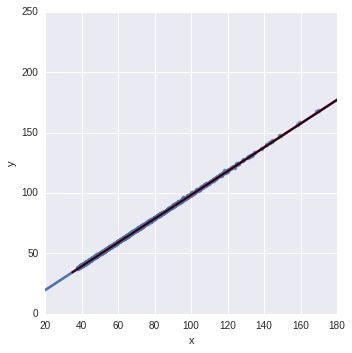

In [246]:
# gmm-fitted mean vs. unweighted mean
x=errlist[(errlist[:,0]!=0)][:,0]
y=errlist[(errlist[:,0]!=0)][:,7]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(y * y)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_ls, b_ls], args=(x, y))
m_ml, b_ml= result["x"]
print m_ml,b_ml
xl = np.array([35, 200])
plt.plot(xl, m_ml*xl+b_ml, color="r", lw=2, alpha=0.8)
plt.plot(xl, m_ls*xl+b_ls, color="k", lw=2, alpha=0.8)
#aaa=200
#plt.plot(range(aaa),range(aaa),c='r')
#plt.xlim(0,aaa)
#plt.ylim(0,aaa)

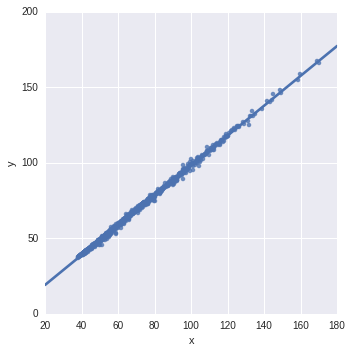

In [247]:
# weighted vs. 50% percentile
x=errlist[(errlist[:,0]!=0)][:,0]
y=errlist[(errlist[:,0]!=0)][:,3]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
#aaa=200
#plt.plot(range(aaa),range(aaa),c='r')
#plt.xlim(0,aaa)
#plt.ylim(0,aaa)

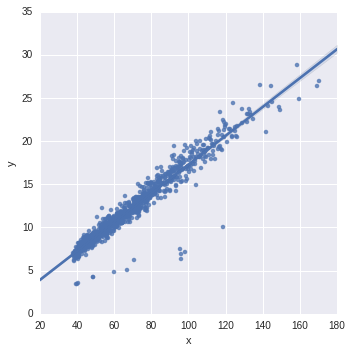

In [248]:
# mean reported error
x=errlist[(errlist[:,0]!=0)][:,0][filter]
y=errlist[(errlist[:,0]!=0)][:,6][filter]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)

0.200856958812 0.514273622431
0.200856959904 0.514273622431


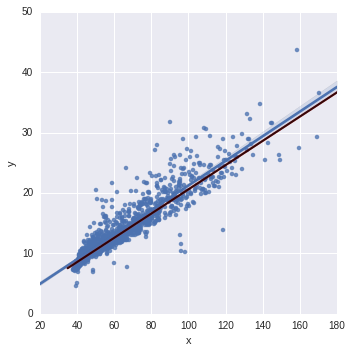

In [429]:
# gmm-fitted sigma
x=errlist[(errlist[:,0]!=0)][:,0][filter]
y=errlist[(errlist[:,0]!=0)][:,2][filter]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(y * y)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_ls, b_ls], args=(x, y))
m_ml, b_ml= result["x"]
print m_ml,b_ml
print m_ls,b_ls
xl = np.array([35, 200])
plt.plot(xl, m_ml*xl+b_ml, color="r", lw=2, alpha=0.8)
plt.plot(xl, m_ls*xl+b_ls, color="k", lw=2, alpha=0.8)

(0, 35)

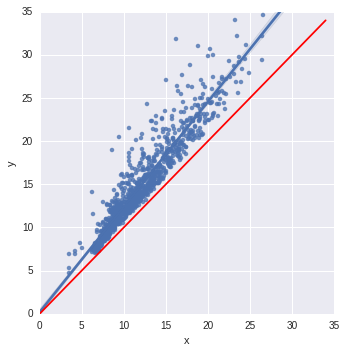

In [36]:
# gmm-fitted sigma vs reported error
x=errlist[(errlist[:,0]!=0)][:,6][filter]
y=errlist[(errlist[:,0]!=0)][:,2][filter]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
aaa=35
plt.plot(range(aaa),range(aaa),c='r')
plt.xlim(0,aaa)
plt.ylim(0,aaa)

0.201641440997 2.45550281687


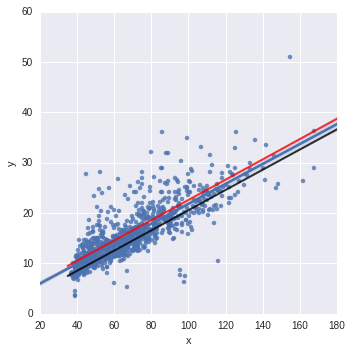

In [51]:
# 84%-16% vs 50%
x=errlist[(errlist[:,0]!=0)][:,3][filter]
y=errlist[(errlist[:,0]!=0)][:,4][filter]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_ls, b_ls], args=(x, y))
m_ml, b_ml= result["x"]
print m_ml,b_ml
xl = np.array([35, 200])
plt.plot(xl, m_ml*xl+b_ml, color="r", lw=2, alpha=0.8)
plt.plot(xl, m_ls*xl+b_ls, color="k", lw=2, alpha=0.8)

0.194389612048 0.0227160657364


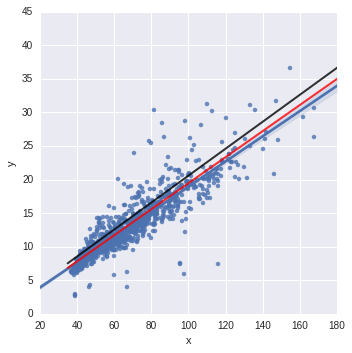

In [50]:
# 16% vs 50%
x=errlist[(errlist[:,0]!=0)][:,3][filter]
y=errlist[(errlist[:,0]!=0)][:,5][filter]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_ls, b_ls], args=(x, y))
m_ml, b_ml= result["x"]
print m_ml,b_ml
xl = np.array([35, 200])
plt.plot(xl, m_ml*xl+b_ml, color="r", lw=2, alpha=0.8)
plt.plot(xl, m_ls*xl+b_ls, color="k", lw=2, alpha=0.8)

In [ ]:
def lnlike(theta, x, y):
    m ,b = theta
    model = m * x +b
    inv_sigma2 = 1.0/((y)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior(theta):
    m, b = theta
    if 0 < m < 1 and -5 < b < 5:
        return 0.0
    return -np.inf
def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

In [ ]:
x=errlist[(errlist[:,0]!=0)][:,0][filter]
y=errlist[(errlist[:,0]!=0)][:,2][filter]

In [287]:
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(y * y)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

In [655]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_ls, b_ls], args=(x, y))
m_ml, b_ml= result["x"]
ndim, nwalkers = 2, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y))
sampler.run_mcmc(pos, 1000);
sampler.chain.shape

(100, 1000, 2)

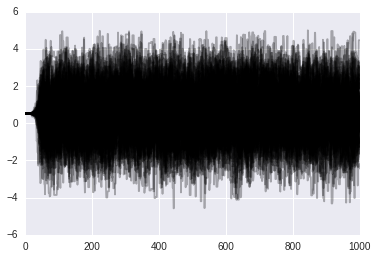

In [656]:
# b
res=plt.plot(sampler.chain[:,:,1].T, '-', color='k', alpha=0.3)


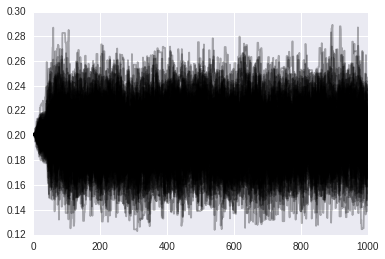

In [657]:
# m
res=plt.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)

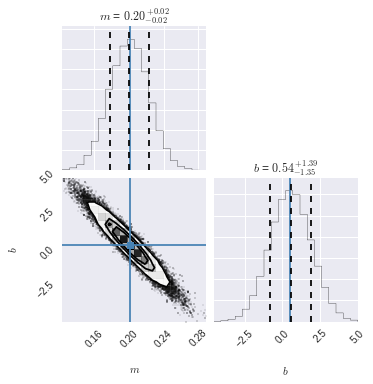

In [658]:
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
sampler.chain.shape
fig = corner.corner(samples, labels=["$m$", "$b$"],
                      truths=[m_ml, b_ml], quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.2f')


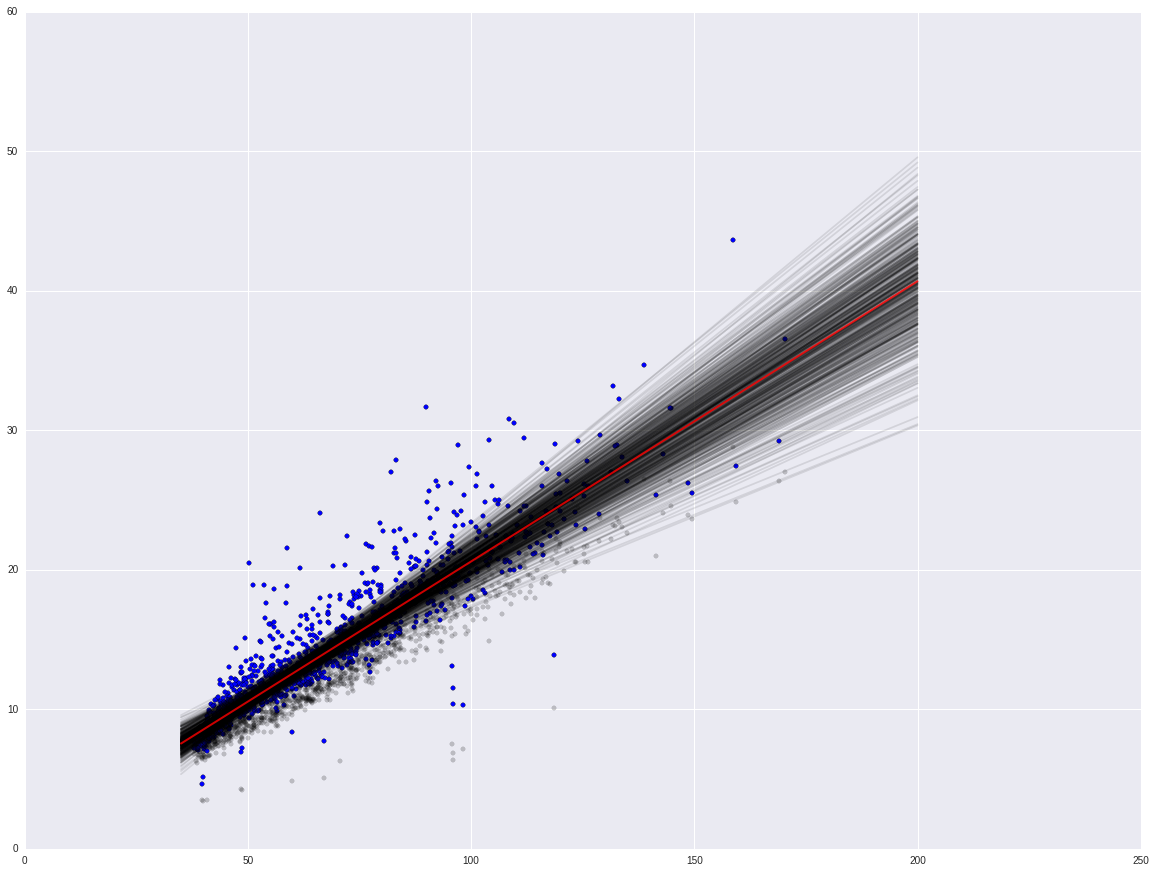

In [659]:
#np.percentile(samples[:,0], 50)
plt.figure(figsize=(20,15))
xl = np.array([35, 200])
for m, b in samples[np.random.randint(len(samples), size=500)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m_ml*xl+b_ml, color="r", lw=2, alpha=0.8)
#plt.plot(xl, m_ls*xl+b_ls, color="y", lw=2, alpha=0.8)
plt.scatter(x,y)
plt.scatter(x,errlist[(errlist[:,0]!=0)][:,6][filter],c='k',alpha=0.2)

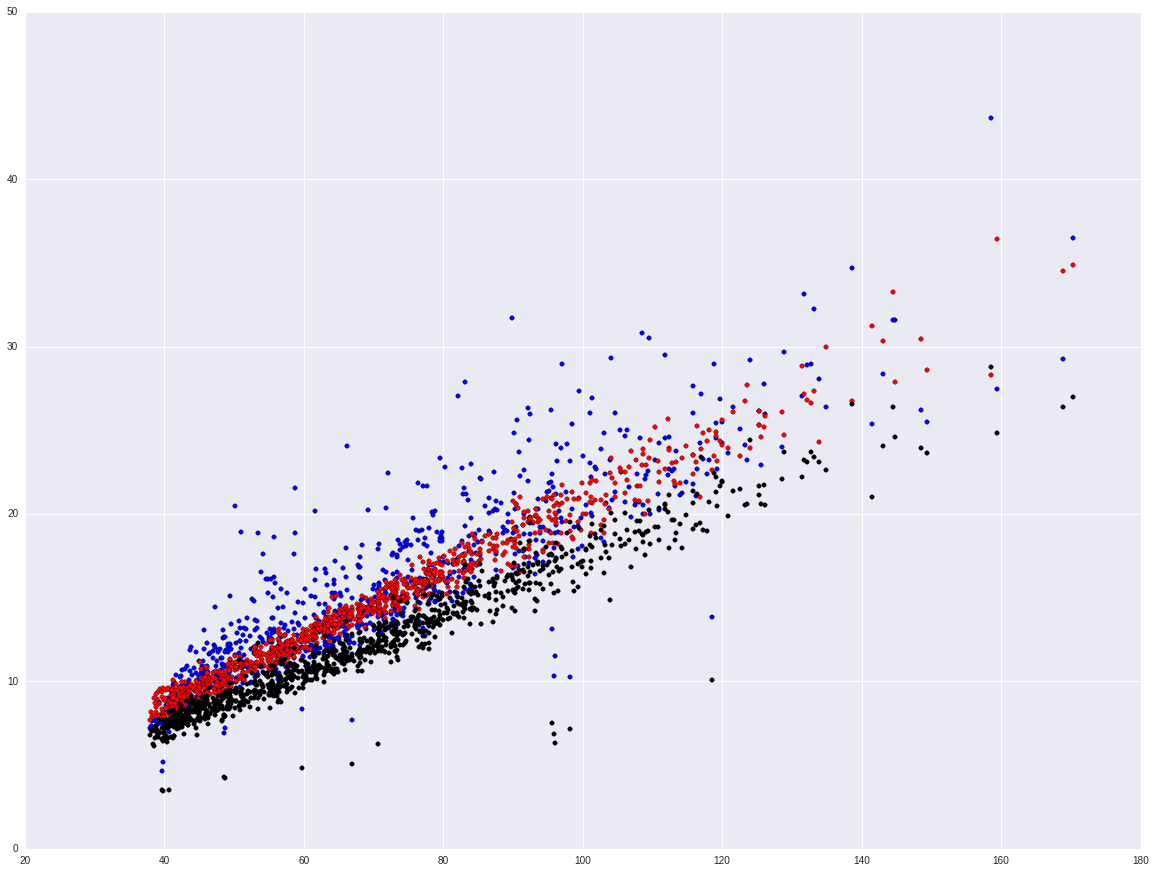

In [663]:
plt.figure(figsize=(20,15))
AAA=samples[np.random.randint(len(samples), size=len(x))]
BBB=samples[np.random.randint(len(samples), size=len(x))]
y_sim=AAA[:,0]*x+AAA[:,1]
plt.scatter(x,y)
plt.scatter(x,y_sim,c='r')
plt.scatter(x,errlist[(errlist[:,0]!=0)][:,6],c='k')

In [692]:
listaksst=[]
listakspv=[]
y_ml=m_ml*x+b_ml
rvs1 = (y)
for i in range(1):
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    BBB=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]
    rvs3 = (y_sim)
    listaksst.append(stats.ks_2samp(rvs1, rvs3)[0])
    listakspv.append(stats.ks_2samp(rvs1, rvs3)[1])
listaksst=np.asarray(listaksst)
listakspv=np.asarray(listakspv)


In [693]:
listakspv

array([ 0.03633922])

In [667]:
-2*(np.log(listakspv)).sum()

53983.381064896035

(array([  320.,  1750.,  3298.,  2351.,  1505.,   629.,    92.,    27.,
           21.,     7.]),
 array([ 0.0089866 ,  0.03008052,  0.05117445,  0.07226838,  0.0933623 ,
         0.11445623,  0.13555015,  0.15664408,  0.17773801,  0.19883193,
         0.21992586]),
 <a list of 10 Patch objects>)

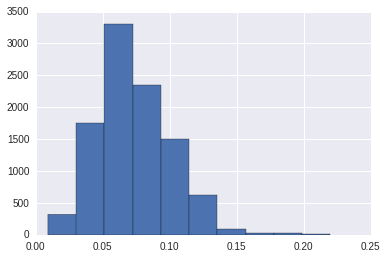

In [666]:
plt.hist(listakspv)

In [698]:
stats.kstest(y-y_ml,'norm')

KstestResult(statistic=0.18274038022025707, pvalue=0.0)

(array([   4.,    2.,    8.,  144.,  555.,  184.,   44.,   20.,    7.,    2.]),
 array([-10.45324755,  -8.09341087,  -5.73357419,  -3.37373751,
         -1.01390083,   1.34593585,   3.70577253,   6.06560921,
          8.42544589,  10.78528257,  13.14511925]),
 <a list of 10 Patch objects>)

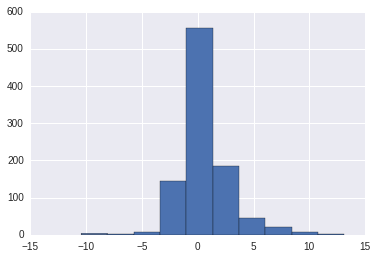

In [701]:
plt.hist(y-y_ml)

(array([   2.,    6.,   27.,  105.,  257.,  309.,  177.,   60.,   21.,    6.]),
 array([-8.95828601, -7.25886708, -5.55944815, -3.86002922, -2.16061029,
        -0.46119136,  1.23822757,  2.9376465 ,  4.63706543,  6.33648436,
         8.0359033 ]),
 <a list of 10 Patch objects>)

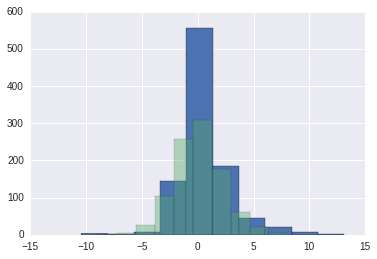

In [560]:
plt.hist(rvs1)
plt.hist(rvs3,alpha=0.4)

(0, 35)

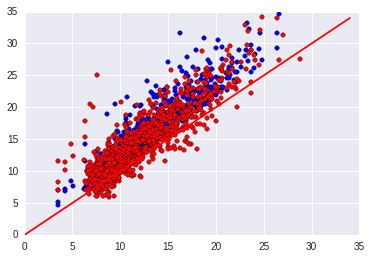

In [445]:
# gmm-fitted sigma vs reported error
AAA=samples[np.random.randint(len(samples), size=len(x))]
BBB=samples[np.random.randint(len(samples), size=len(x))]
xx=errlist[(errlist[:,0]!=0)][:,6][filter]
yy=errlist[(errlist[:,0]!=0)][:,2][filter]
plt.scatter(xx,yy)
plt.scatter(xx,AAA[:,0]*x+BBB[:,1],c='r')
aaa=35
plt.plot(range(aaa),range(aaa),c='r')
plt.xlim(0,aaa)
plt.ylim(0,aaa)

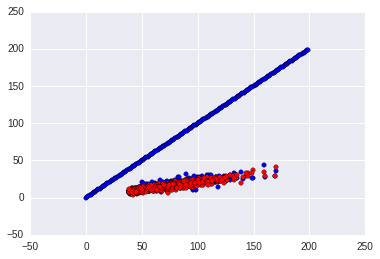

In [464]:
AAA=samples[np.random.randint(len(samples), size=len(x))]
BBB=samples[np.random.randint(len(samples), size=len(x))]
plt.scatter(x,y)
plt.scatter(x,AAA[:,0]*x+BBB[:,1],c='r')
aaa=np.arange(200)
plt.scatter(aaa,aaa)

In [1512]:
yerr=errlist[(errlist[:,0]!=0)][:,6] # average - pasa el ks-test pero el p-value de discrepancias no
# pasa el ks test (p<0.05 con un draw para cada tres parametros). con tres draw no pasa el ks-test
# con uno o con tres draws a veces predice valores negativos para el error :(
# pidiendo positividad en los parámetros no funciona el mcmc
# se podría re-simular pidiendo positividad en y cuando un dato salga malo?

In [1520]:
yerr=errlist[(errlist[:,0]!=0)][:,8] 
# minimum - pasa el ks-test casi siempre pero su estadística no es chi-2 (p~1) ni con un draw ni con tres draw
# p-value bayesiano no muestra inconsistencia, (con tres draw para tres parametros), p~0.9<0.975 pero a veces genera
# errores negativos
# con un solo draw el p-value bayesiano si muestra inconsistencia
# con un prior pidiendo positividad de los parámetros, no pasamos el ks-test
# pero para tres draws el bayesian p-value es muy bueno p~0.6

In [1521]:
def lnlike(theta, x, y,yerr):
    m ,b,f = theta
    model = m * x +b+f*yerr
    inv_sigma2 = 1.0/((y)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior(theta):
    m, b,f = theta
    if 0 < m < 1 and 0 < b < 5 and 0<f<10:
        return 0.0
    return -np.inf
def lnprob(theta, x, y,yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y,yerr)


In [1522]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_ls, b_ls,0.5], args=(x, y,yerr))
m_ml, b_ml,f_ml= result["x"]
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y,yerr))
sampler.run_mcmc(pos, 1000);
sampler.chain.shape

(100, 1000, 3)

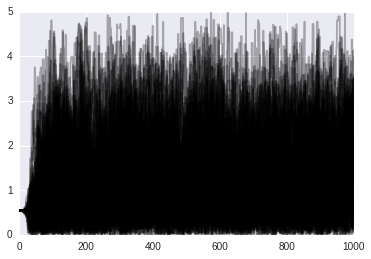

In [1523]:
# b
res=plt.plot(sampler.chain[:,:,1].T, '-', color='k', alpha=0.3)

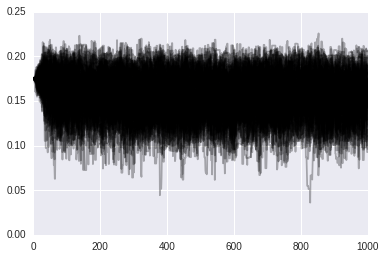

In [1524]:
# m
res=plt.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)

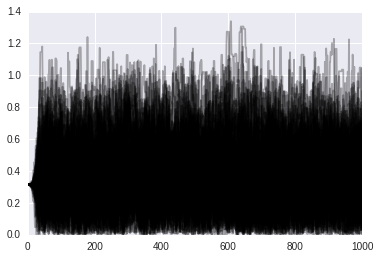

In [1525]:
# f
res=plt.plot(sampler.chain[:,:,2].T, '-', color='k', alpha=0.3)

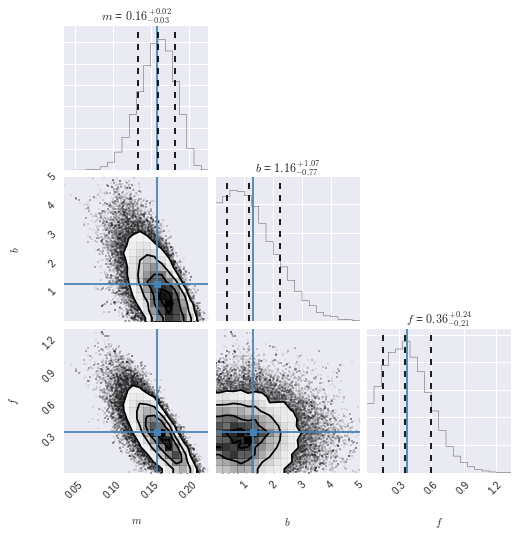

In [1526]:
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
meanest=samples.mean(axis=0)
fig = corner.corner(samples, labels=["$m$", "$b$","$f$"],
                      truths=[meanest[0], meanest[1],meanest[2]], quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.2f')

In [1527]:
xl, yerrl = (list(x) for x in zip(*sorted(zip(x, yerr))))
xl,yerrl=np.asarray(xl),np.asarray(yerrl)

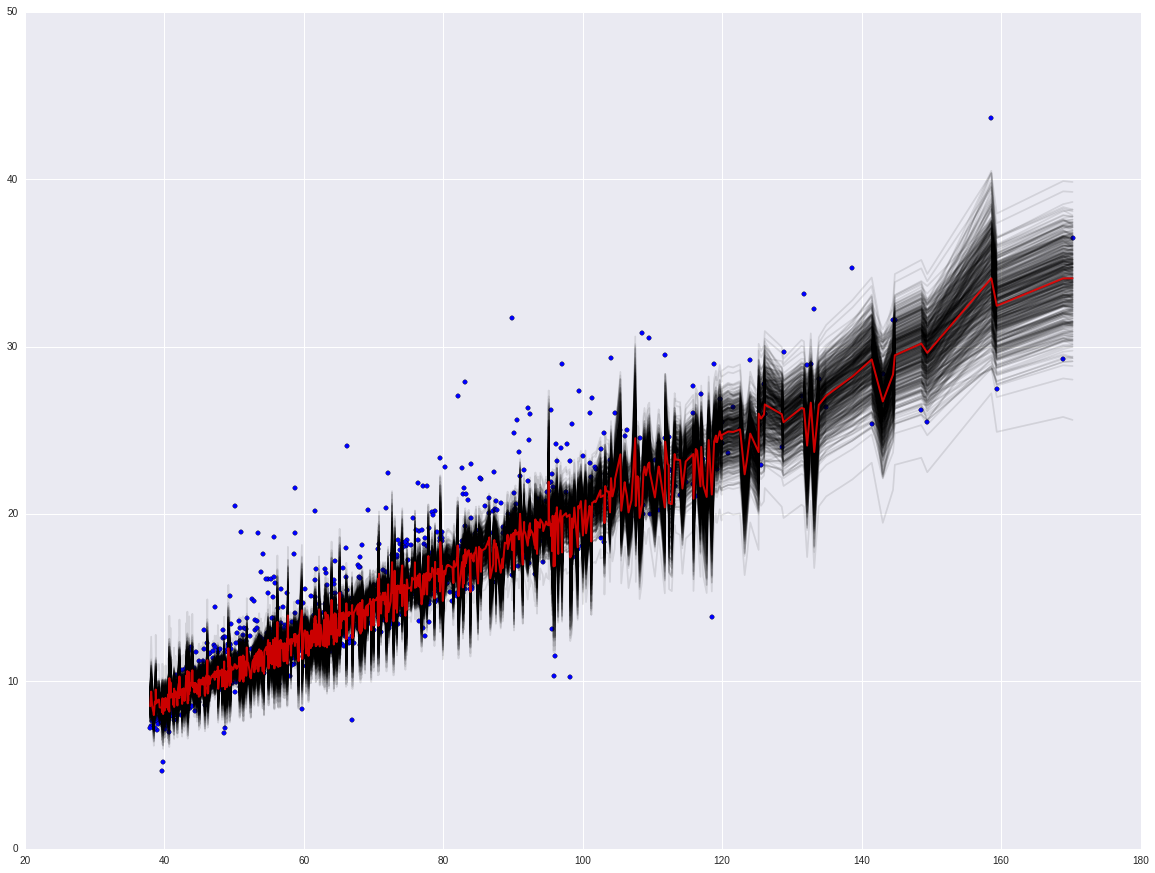

In [1528]:
plt.figure(figsize=(20,15))
for m, b, f in samples[np.random.randint(len(samples), size=500)]:
    plt.plot(xl, m*xl+b+f*yerrl, color="k", alpha=0.1)
plt.plot(xl, meanest[0]*xl+meanest[1]+meanest[2]*yerrl, color="r", lw=2, alpha=0.8)
plt.scatter(x,y)
#plt.scatter(x,errlist[(errlist[:,0]!=0)][:,6][filter],c='k',alpha=0.2)

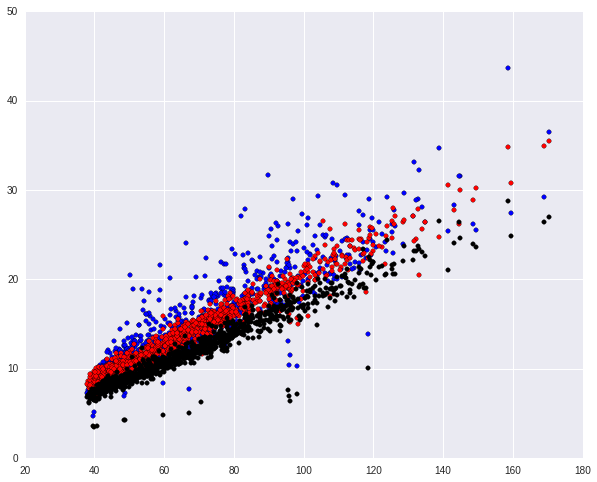

In [1534]:
plt.figure(figsize=(10,8))
AAA=samples[np.random.randint(len(samples), size=len(x))]
plt.scatter(x,y)
plt.scatter(x,AAA[:,0]*x+AAA[:,1]+AAA[:,2]*yerr,c='r')
plt.scatter(x,errlist[(errlist[:,0]!=0)][:,6],c='k')

In [1540]:
listaksst=[]
listakspv=[]
y_ml=meanest[0]*xl+meanest[1]+meanest[2]*yerrl
rvs1 = (y-y_ml)
ndsets=5000
for i in range(ndsets):
    AAA=samples[np.random.randint(len(samples), size=len(x))]
#    BBB=samples[np.random.randint(len(samples), size=len(x))]
#    CCC=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*yerr
    rvs3 = (y_sim-y_ml)
    listaksst.append(stats.ks_2samp(rvs1, rvs3)[0])
    listakspv.append(stats.ks_2samp(rvs1, rvs3)[1])
listaksst=np.asarray(listaksst)
listakspv=np.asarray(listakspv)
# crit=34.8 for n=25
cpval=-2*(np.log(listakspv)).sum()

In [1541]:
stats.chi2.cdf(cpval, 2*ndsets)

1.0

(array([   1.,    5.,   27.,  179.,  340.,  266.,  101.,   38.,   11.,    2.]),
 array([-26.24850745, -20.77099309, -15.29347872,  -9.81596436,
         -4.33844999,   1.13906438,   6.61657874,  12.09409311,
         17.57160748,  23.04912184,  28.52663621]),
 <a list of 10 Patch objects>)

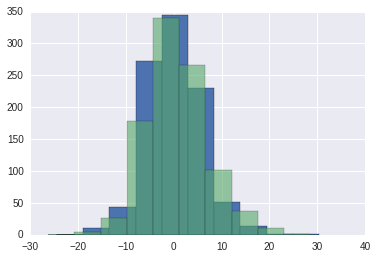

In [1542]:
plt.hist(y_sim-y_ml)
plt.hist(y-y_ml,alpha=0.6)

In [1543]:
(listakspv>0.05).sum()

4944

(array([  104.,   685.,  1398.,  1120.,   958.,   325.,   318.,    51.,
           23.,    18.]),
 array([ 0.02442597,  0.05646347,  0.08850097,  0.12053847,  0.15257597,
         0.18461347,  0.21665096,  0.24868846,  0.28072596,  0.31276346,
         0.34480096]),
 <a list of 10 Patch objects>)

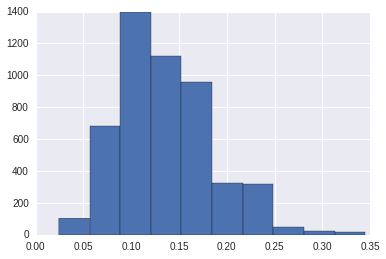

In [1544]:
stats.chi2.cdf(cpval, 2*ndsets)
plt.hist(listakspv)

(0, 35)

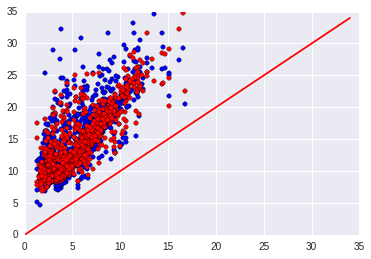

In [1548]:
# gmm-fitted sigma vs reported error
AAA=samples[np.random.randint(len(samples), size=len(x))]

xx=errlist[(errlist[:,0]!=0)][:,8][filter]
yy=errlist[(errlist[:,0]!=0)][:,2][filter]
plt.scatter(xx,yy)
plt.scatter(xx,AAA[:,0]*x+AAA[:,1]+AAA[:,2]*yerr,c='r')
aaa=35
plt.plot(range(aaa),range(aaa),c='r')
plt.xlim(0,aaa)
plt.ylim(0,aaa)

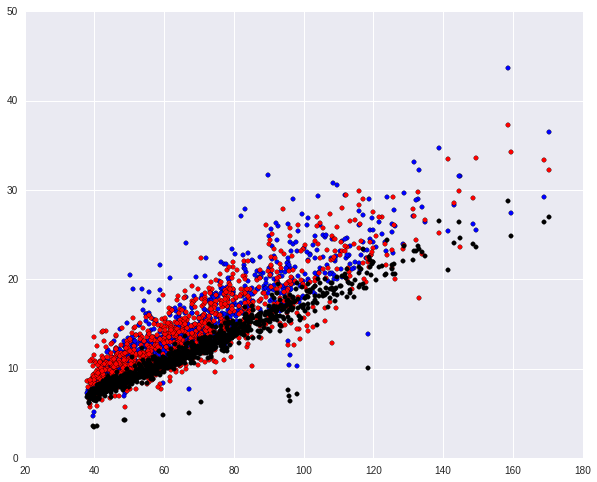

In [1506]:
plt.figure(figsize=(10,8))
AAA=samples[np.random.randint(len(samples), size=len(x))]
BBB=samples[np.random.randint(len(samples), size=len(x))]
CCC=samples[np.random.randint(len(samples), size=len(x))]
plt.scatter(x,y)
plt.scatter(x,AAA[:,0]*x+BBB[:,1]+CCC[:,2]*yerr,c='r')

plt.scatter(x,errlist[(errlist[:,0]!=0)][:,6],c='k')

In [1507]:
discobs=[]
discsim=[]
for m,b,f in samples[np.random.randint(len(samples), size=50000)]:
    b=samples[np.random.randint(len(samples), size=1)][:,1]
    f=samples[np.random.randint(len(samples), size=1)][:,2]
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    BBB=samples[np.random.randint(len(samples), size=len(x))]
    CCC=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+BBB[:,1]+CCC[:,2]*yerr
    yexp=m*x+b+f*yerr
    discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
    discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)

In [1508]:
np.isnan(discsim).sum()

0

0.63602


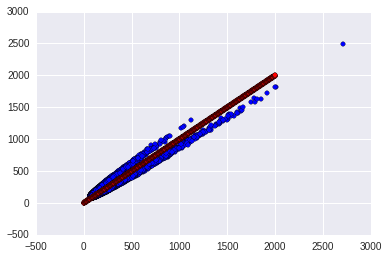

In [1511]:
plt.scatter(discobs,discsim)
print (discobs<discsim).sum()*1./(len(discobs)-np.isnan(discsim).sum())
ppp=np.arange(2000)
plt.scatter(ppp,ppp,c='r')

In [1556]:
discobs=[]
discsim=[]
for m,b,f in samples[np.random.randint(len(samples), size=50000)]:
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*yerr
    yexp=m*x+b+f*yerr
    discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
    discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)

In [1557]:
np.isnan(discsim).sum()

0

0.0


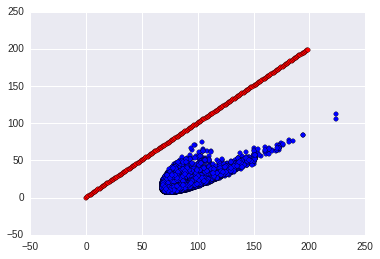

In [1559]:
plt.scatter(discobs,discsim)
print (discobs<discsim).sum()*1./len(discobs)
ppp=np.arange(200)
plt.scatter(ppp,ppp,c='r')

In [862]:
((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum()

32.230871010375914

In [855]:
AAA=samples[np.random.randint(len(samples), size=len(x))]
y_sim=AAA[:,0]*x+AAA[:,1]+AAA[:,2]*yerr

In [1560]:

def lnlike(theta, x, y,yerr):
    m ,f = theta
    model = m * x +f*yerr
    inv_sigma2 = 1.0/((y)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior(theta):
    m,f = theta
    if 0 < m < 1 and 0<f<10:
        return 0.0
    return -np.inf
def lnprob(theta, x, y,yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y,yerr)


In [1561]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_ls,0.5], args=(x, y,yerr))
m_ml,f_ml= result["x"]
ndim, nwalkers = 2, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y,yerr))
sampler.run_mcmc(pos, 1000);
sampler.chain.shape

(100, 1000, 2)

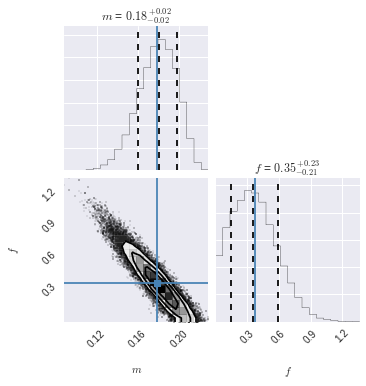

In [1563]:
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
meanest=samples.mean(axis=0)
fig = corner.corner(samples, labels=["$m$","$f$"],
                      truths=[meanest[0], meanest[1]], quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.2f')

In [1564]:
xl, yerrl = (list(x) for x in zip(*sorted(zip(x, yerr))))
xl,yerrl=np.asarray(xl),np.asarray(yerrl)

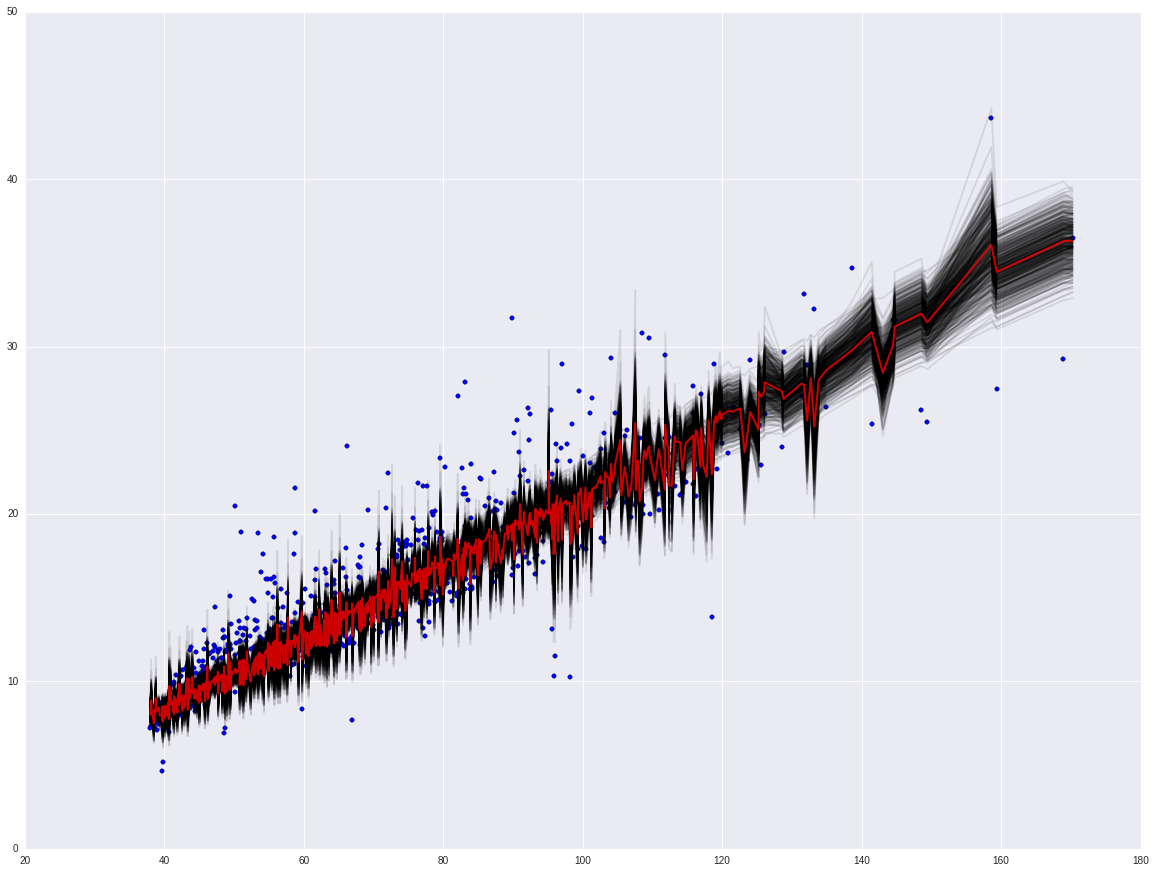

In [1565]:
plt.figure(figsize=(20,15))
for m, f in samples[np.random.randint(len(samples), size=500)]:
    plt.plot(xl, m*xl+f*yerrl, color="k", alpha=0.1)
plt.plot(xl, meanest[0]*xl+meanest[1]*yerrl, color="r", lw=2, alpha=0.8)
plt.scatter(x,y)
#plt.scatter(x,errlist[(errlist[:,0]!=0)][:,6][filter],c='k',alpha=0.2)

In [1566]:
listaksst=[]
listakspv=[]
y_ml=meanest[0]*xl+meanest[1]*yerrl
rvs1 = (y-y_ml)
ndsets=5000
for i in range(ndsets):
    AAA=samples[np.random.randint(len(samples), size=len(x))]
#    BBB=samples[np.random.randint(len(samples), size=len(x))]
#    CCC=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]*yerr
    rvs3 = (y_sim-y_ml)
    listaksst.append(stats.ks_2samp(rvs1, rvs3)[0])
    listakspv.append(stats.ks_2samp(rvs1, rvs3)[1])
listaksst=np.asarray(listaksst)
listakspv=np.asarray(listakspv)
# crit=34.8 for n=25
cpval=-2*(np.log(listakspv)).sum()

1.0


(array([  1.60000000e+01,   2.64000000e+02,   6.08000000e+02,
          1.71900000e+03,   1.23800000e+03,   7.97000000e+02,
          2.89000000e+02,   4.70000000e+01,   2.10000000e+01,
          1.00000000e+00]),
 array([ 0.07602442,  0.13824116,  0.2004579 ,  0.26267464,  0.32489138,
         0.38710812,  0.44932486,  0.5115416 ,  0.57375834,  0.63597508,
         0.69819182]),
 <a list of 10 Patch objects>)

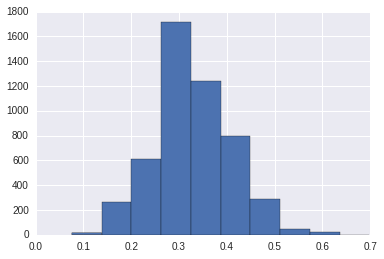

In [1568]:
print stats.chi2.cdf(cpval, 2*ndsets)
plt.hist(listakspv)

In [1570]:
discobs=[]
discsim=[]
for m,f in samples[np.random.randint(len(samples), size=50000)]:
    AAA=samples[np.random.randint(len(samples), size=len(x))]
    y_sim=AAA[:,0]*x+AAA[:,1]*yerr
    yexp=m*x+f*yerr
    discobs.append(((np.sqrt(y)-np.sqrt(yexp))**2).sum())
    discsim.append(((np.sqrt(y_sim)-np.sqrt(yexp))**2).sum())
discobs=np.asarray(discobs)
discsim=np.asarray(discsim)

0.0


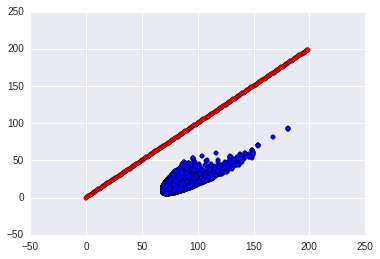

In [1571]:
plt.scatter(discobs,discsim)
print (discobs<discsim).sum()*1./len(discobs)
ppp=np.arange(200)
plt.scatter(ppp,ppp,c='r')

In [1064]:
%%time
from scipy.optimize import curve_fit

hist, bin_edges = np.histogram(data, density=True,bins=nbins)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
p0 = [hist.max(), data.mean(), data.std()]
coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
hist_fit = gauss(bin_centres, *coeff)
print 'Fitted mean = ', coeff[1]/1e6
print 'Fitted standard deviation = ', coeff[2]/1e6
plt.show()

Fitted mean =  80.2544179399
Fitted standard deviation =  18.4722080092
CPU times: user 136 ms, sys: 0 ns, total: 136 ms
Wall time: 134 ms


102.53132963259658

In [591]:
observed_values=scipy.array([18,21,16,7,15])
expected_values=scipy.array([22,24,18,8,16])

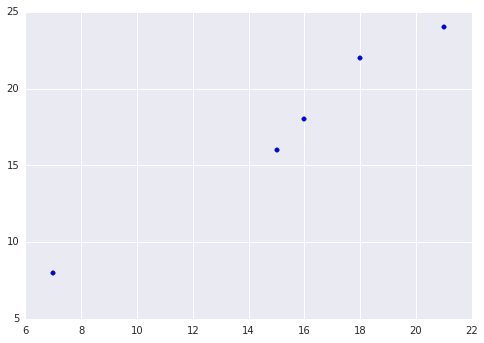

In [592]:
plt.scatter(observed_values,expected_values)

In [593]:
chisquare(observed_values, f_exp=expected_values)

(1.5119949494949494, 0.82451460975493762)

In [611]:
from pymc import discrepancy

In [612]:
discrepancy?

In [683]:
samples[:,1]

array([ 0.06197629,  0.00647111, -0.00281858, ...,  0.00010253,
        0.00010253, -0.00042499])

In [672]:
y_sim=samples[:10000,1]+samples[:10000,0]*x[:,np.newaxis]

In [723]:
y_sim[:,1].shape

(970,)

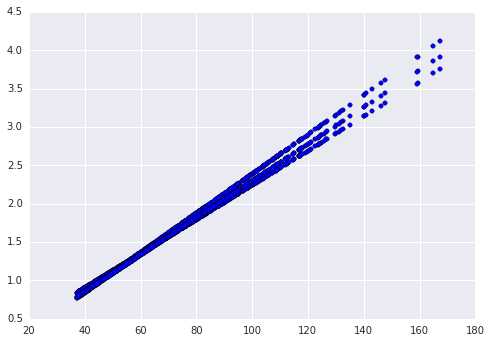

In [743]:
plt.scatter(x,y_sim[:,1])
plt.scatter(x,y_sim[:,46])
plt.scatter(x,y_sim[:,1046])

In [750]:
y_sim[0].shape

(10000,)

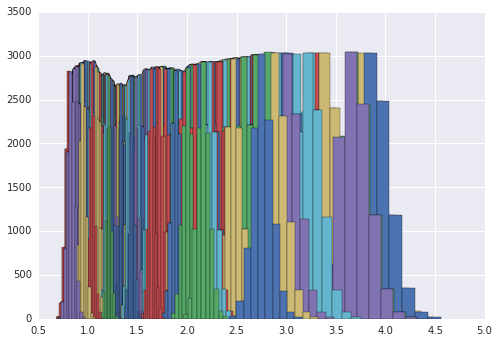

In [759]:
exval=np.zeros(len(x))
for i in range(len(x)):
    a=plt.hist(y_sim[i])
    exval[i]=a[1][np.argmax(a[0])]

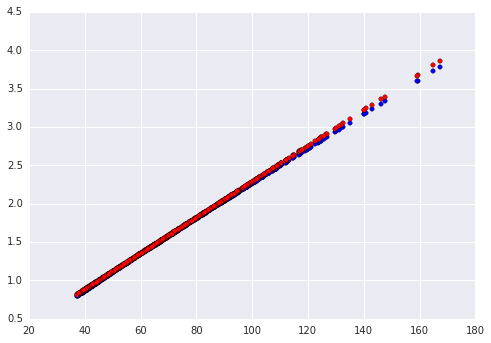

In [762]:
plt.scatter(x,exval)
plt.scatter(x,m_ml*x+b_ml,c='r')

In [758]:
a[1][np.argmax(a[0])]

0.8453260043563634

In [739]:
y_sim[:,1]

array([ 2.12954092,  2.83866704,  2.03188369,  2.45123834,  3.69771867,
        3.2752848 ,  1.83468003,  1.56684972,  2.34664502,  1.51986986,
        1.87029733,  2.43349435,  2.90415769,  2.43436888,  2.62324847,
        1.38003128,  1.38402589,  1.14946141,  0.98646209,  1.43617898,
        1.56916191,  1.55802806,  2.27352342,  1.59936609,  2.22669686,
        1.37429958,  1.3191688 ,  1.64640293,  1.37153023,  1.21107077,
        0.893302  ,  1.85233186,  1.33141409,  2.01776712,  1.23303085,
        1.44183413,  1.32267968,  1.88651347,  1.53639766,  2.13808901,
        1.0070031 ,  1.53587196,  0.89759464,  2.46775271,  1.95603882,
        2.23903992,  1.1712968 ,  1.73660471,  1.58676691,  2.04916815,
        1.60709763,  0.93689241,  2.47574265,  1.64992413,  1.50817224,
        1.75132058,  1.46472237,  1.02257889,  0.93117526,  0.94979991,
        0.88587432,  0.99005931,  1.20772342,  1.19322406,  1.00061183,
        1.83582454,  0.99234677,  1.61538471,  1.69343182,  1.83

In [713]:
y_exp=y_sim.sum(axis=0)

In [714]:
D=discrepancy(y,y_sim.T,y_exp)

Bayesian p-value: p=1.000


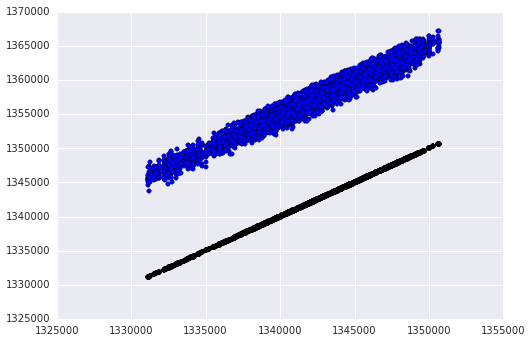

In [715]:
plt.scatter(D[0],D[1])
plt.scatter(D[0],D[0],c='k')

In [658]:
y_sim.shape

(970, 45000)

In [690]:
import pymc as mc
import numpy as np
alpha = 2
beta = 2
n = 13
yes = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,0,0])

p = mc.Beta('p',alpha,beta)
surv = mc.Bernoulli('surv',p=p,observed=True,value=yes)
surv_sim = mc.Bernoulli('surv_sim', p=p, size=n)

mc_est = mc.MCMC({'p':p,'surv':surv,'surv_sim':surv_sim})
mc_est.sample(10000,5000,2)


#here I have issues
D = mc.discrepancy(yes, surv_sim.trace(), mc.bernoulli_expval(p.trace()))

 [-----------------100%-----------------] 10000 of 10000 complete in 0.3 secBayesian p-value: p=0.594


In [694]:
p.trace()

array([ 0.68595081,  0.70447522,  0.70447522, ...,  0.81121508,
        0.81121508,  0.81121508])

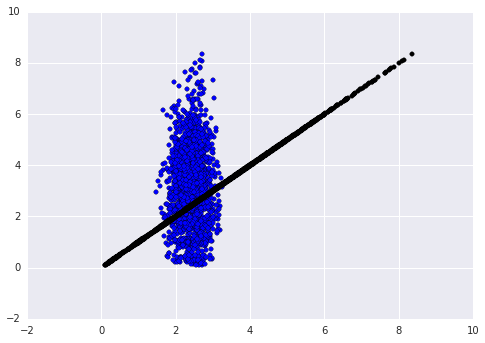

In [688]:
plt.scatter(D[0],D[1])
plt.scatter(D[1],D[1],c='k')

https://hflog.wordpress.com/2014/04/01/how-to-perform-a-chi-squared-goodness-of-fit-test-in-python/

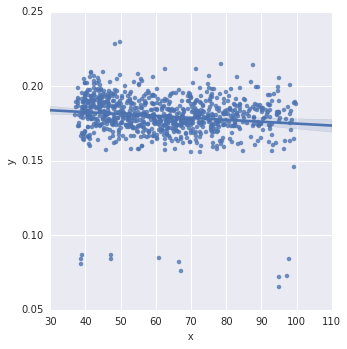

In [393]:
# mean reported error
x=errlist[(errlist[:,0]!=0)][:,0][filter]
y=errlist[(errlist[:,0]!=0)][:,6][filter]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)

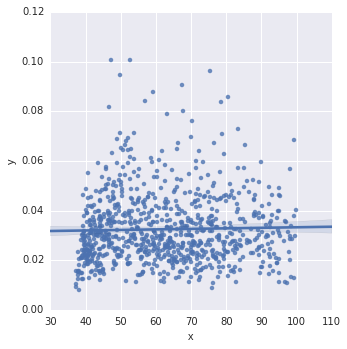

In [395]:
# weighted standard deviation vs unweighted standard deviation for n>4
x=errlist[(errlist[:,0]!=0)][:,0][filter]
y=errlist[(errlist[:,0]!=0)][:,2][filter]/x
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)

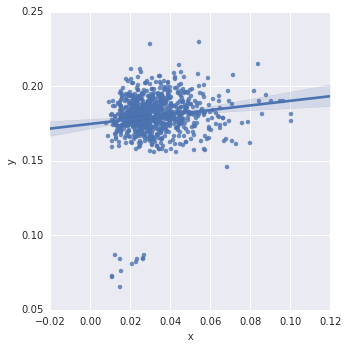

In [405]:
# weighted standard deviation relative error vs mean relative error
# NO CORRELATION
x=errlist[(errlist[:,0]!=0)][:,2][filter]/errlist[(errlist[:,0]!=0)][:,0][filter]
y=errlist[(errlist[:,0]!=0)][:,6][filter]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
#plt.plot(range(35),range(35))

(0, 20)

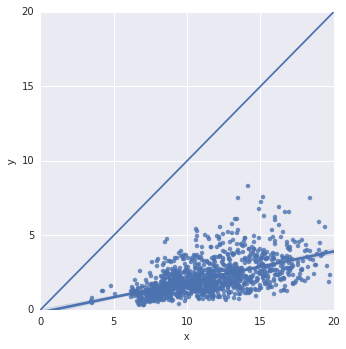

In [368]:
# mean reported error vs weighted standard deviation for n>4
x=errlist[(errlist[:,0]!=0)][:,3][filter]
y=errlist[(errlist[:,0]!=0)][:,2][filter]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
plt.plot(range(35),range(35))
plt.xlim(0,20)
plt.ylim(0,20)

(0, 20)

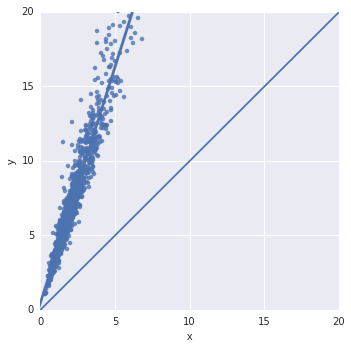

In [370]:
# weighted standard deviation vs unweighted standard deviation for n>4
x=errlist[(errlist[:,0]!=0)][:,2][filter]
y=errlist[(errlist[:,0]!=0)][:,4][filter]
df5=pd.DataFrame({'x' : x, 'y': y})
sns.lmplot(x="x", y="y", data=df5)
plt.plot(range(35),range(35))
plt.xlim(0,20)
plt.ylim(0,20)

In [193]:
listcut[errlist[:,0]!=0]

array(['2MASX J04191179+5552439', '2MASX J04451775+4049326',
       '2MASX J05154347+1921467', ..., 'WEIN 033', 'WEIN 069', 'WEIN 171'], dtype=object)

In [189]:
np.unique(df1.Method[dfilter])

array(['Tully-Fisher'], dtype=object)

In [114]:
listnames=np.unique(df['Galaxy ID'])

In [136]:
errlist.shape

(19965, 4)

In [219]:

dfilter=(df['Galaxy ID']==listcut[np.argmax(errlist[:,2])])
dummy=df[dfilter]
dumerr=disterr[dfilter]
em=len(dumerr)
dumw=dumerr
wave=(dummy['D (Mpc)']*1/dumw**2).sum()/(1/dumw**2).sum()
wstd=np.sqrt((((dummy['D (Mpc)']-wave)**2)*1/dumw**2).sum()/((em-1./em)*(1/dumw**2).sum()))
werr=wstd/c4(em)
print dummy['D (Mpc)'].mean(),wave, em,werr,dumerr.mean()

139.5 104.506007259 4 22.4142542011 29.06144


In [218]:
dummy['D (Mpc)'].std()

42.406760467328006

In [212]:
dumerr

7079    14.01440
7081    33.50548
7082    33.19200
7083    35.53388
dtype: float64

In [213]:
dummy['D (Mpc)']*1/dumerr**2

7079    0.386959
7081    0.140743
7082    0.145229
7083    0.129885
dtype: float64

In [74]:
dummy

,Exclusion Code,D,G,Galaxy ID,m-M,err,D (Mpc),Method,REFCODE,SN ID,redshift (z),Hubble const.,Adopted LMC modulus,Date (Yr. - 1980),Notes
4,NaN,3,2,UGC 12889,34.16,0.40,68.0,Tully-Fisher,2007A&A...465...71T,NaN,NaN,NaN,NaN,27,mean
5,NaN,4,2,UGC 12889,34.66,0.45,85.6,Tully-Fisher,2007A&A...465...71T,NaN,NaN,NaN,NaN,27,K
6,NaN,5,2,UGC 12889,34.68,0.47,86.1,Tully-Fisher,2007A&A...465...71T,NaN,NaN,NaN,NaN,27,H
7,NaN,6,2,UGC 12889,34.70,0.46,86.9,Tully-Fisher,2007A&A...465...71T,NaN,NaN,NaN,NaN,27,J


In [53]:
listerr
for i in listcut:
    if(len(df['Galaxy ID'][df['Galaxy ID']==i])>4):
        

(19965,)

In [9]:
listrs=np.unique(df['Galaxy ID'][np.isnan(df['redshift (z)'])])

In [17]:
list1=[]
for k in range(len(listrs)):
    if(len(df[df['Galaxy ID']==listrs[k]])>4):
        list1.append(listrs[k])

In [19]:
len(list1)

6957